In [751]:
#Importamos las librerias que vamos a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import matplotlib.cm as cm
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from yellowbrick.cluster import SilhouetteVisualizer
plt.style.use('ggplot')
%matplotlib inline

Lectura y Limpieza de datos:

In [752]:
#Leemos el dataset
df = pd.read_csv("df.csv")
df.shape

/Users/pablo/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,6,7,9,23,24,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(238674, 44)

In [753]:
df.columns

Index(['Unnamed: 0', 'order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'costo_envio', 'review_id',
       'review_score', 'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'payment_sequential', 'payment_type',
       'cuotas', 'payment_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'geo_lat_customer', 'geo_lng_customer', 'geo_lat_seller',
       'geo_lng_seller'],
    

In [754]:
# Vemos cuando customers tenemos que es a quienes queremos segmentar
len(df.customer_id.value_counts())

69924

In [755]:
# Definimos un dataset con algunas columnas que creemos que nos pueden interesar y lo exploramos:
df_pre = df[['order_id', 'product_id', 'product_category_name', 'order_purchase_timestamp', 'price', 'customer_id','customer_city']]
df_pre.head()

,order_id,product_id,product_category_name,order_purchase_timestamp,price,customer_id,customer_city
0,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,utilidades_domesticas,2017-10-02 10:56:33,29.99,9ef432eb6251297304e76186b10a928d,sao paulo
1,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,utilidades_domesticas,2017-10-02 10:56:33,29.99,9ef432eb6251297304e76186b10a928d,sao paulo
2,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,utilidades_domesticas,2017-10-02 10:56:33,29.99,9ef432eb6251297304e76186b10a928d,sao paulo
3,de01100645b731556de153cfbebc35b1,725cbfcaff95a4d43742fdf13cf43c75,cool_stuff,2017-08-07 12:13:26,44.99,94602ee2b2723266d391c94e7d1f4d89,ouro preto
4,e55fb3457f263ce9c93e88a934d7cc17,5a419dbf24a8c9718fe522b81c69f61a,cool_stuff,2017-09-06 09:52:11,48.9,f185f0c103eaf4cdb003c5fd33d29a9c,hortolandia


In [756]:
df_pre.shape

(238674, 7)

In [757]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238674 entries, 0 to 238673
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   order_id                  238674 non-null  object
 1   product_id                238674 non-null  object
 2   product_category_name     235974 non-null  object
 3   order_purchase_timestamp  238665 non-null  object
 4   price                     238674 non-null  object
 5   customer_id               238665 non-null  object
 6   customer_city             238656 non-null  object
dtypes: object(7)
memory usage: 12.7+ MB


In [758]:
df_pre.describe()

,order_id,product_id,product_category_name,order_purchase_timestamp,price,customer_id,customer_city
count,238674,238674,235974,238665,238674.0,238665,238656
unique,69926,19999,74,69597,4596.0,69924,3697
top,428a2f660dc84138d969ccd69a0ab6d5,422879e10f46682990de24d770e7f83d,cama_mesa_banho,2017-11-23 20:30:52,59.9,10de381f8a8d23fff822753305f71cae,sao paulo
freq,3375,5495,32128,3375,6323.0,3375,37768


In [759]:
df_pre_null = round(100*(df_pre.isnull().sum())/len(df_pre), 2)
df_pre_null

order_id                    0.00
product_id                  0.00
product_category_name       1.13
order_purchase_timestamp    0.00
price                       0.00
customer_id                 0.00
customer_city               0.01
dtype: float64

In [760]:
# Eliminamos las observaciones con datos nulos:
df_pre = df_pre.dropna()
df_pre.shape

(235965, 7)

In [761]:
# Convertimos precio en numérica:
df_pre['price'] = df_pre['price'].astype(float)

In [762]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235965 entries, 0 to 238673
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  235965 non-null  object 
 1   product_id                235965 non-null  object 
 2   product_category_name     235965 non-null  object 
 3   order_purchase_timestamp  235965 non-null  object 
 4   price                     235965 non-null  float64
 5   customer_id               235965 non-null  object 
 6   customer_city             235965 non-null  object 
dtypes: float64(1), object(6)
memory usage: 14.4+ MB


Feature Engineering para obtener un dataset apto para Clustering:

In [763]:
# Agrupamos por customer en precio y sumamos para obtener el total de gasto por customer:
df_pre_g = df_pre.groupby('customer_id')['price'].sum()
df_pre_g = df_pre_g.reset_index()
df_pre_g.head()

,customer_id,price
0,00012a2ce6f8dcda20d059ce98491703,89.80
1,0001fd6190edaaf884bcaf3d49edf079,179.99
2,0002414f95344307404f0ace7a26f1d5,149.90
3,000379cdec625522490c315e70c7a9fb,93.00
4,0004164d20a9e969af783496f3408652,59.99


In [764]:
# Agrupamos por customer en orden de compra y contamos para obtener el total de operaciones por cliente:
df_pre_f = df_pre.groupby('customer_id')['order_id'].count()
df_pre_f = df_pre_f.reset_index()
df_pre_f.columns = ['customer_id', 'frecuencia']
df_pre_f.sample(5)

,customer_id,frecuencia
34334,7f4a30f8ff8f5bf42df32a7f52a710d9,1
55815,ce4918541808858e8b59af10d2d0e229,216
62874,e898665675636de89a1bead880858c95,1
2581,09a4d9a39e24d6a253196acf5a41358d,1
24193,59e64c4606d914bfa86bcf280f16bfeb,1


In [765]:
# Unimos ambos df:
df_pre_fm = pd.merge(df_pre_g, df_pre_f, on='customer_id', how='inner')
df_pre_fm.head()


,customer_id,price,frecuencia
0,00012a2ce6f8dcda20d059ce98491703,89.80,1
1,0001fd6190edaaf884bcaf3d49edf079,179.99,1
2,0002414f95344307404f0ace7a26f1d5,149.90,1
3,000379cdec625522490c315e70c7a9fb,93.00,1
4,0004164d20a9e969af783496f3408652,59.99,1


In [766]:
# Convertimos en datetime la columna timestamp:
df_pre['order_purchase_timestamp'] = pd.to_datetime(df_pre['order_purchase_timestamp'],format='%Y-%m-%d %H:%M')

In [767]:
# Ubicamos la compra mas reciente del df:
mas_reciente = max(df_pre['order_purchase_timestamp'])
mas_reciente

Timestamp('2018-08-29 15:00:37')

In [768]:
# Creamos la columna DIF para obtener los días que transcurrieron desde cada operación:
df_pre['dif'] = mas_reciente - df_pre['order_purchase_timestamp']
df_pre.head()

,order_id,product_id,product_category_name,order_purchase_timestamp,price,customer_id,customer_city,dif
0,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,utilidades_domesticas,2017-10-02 10:56:33,29.99,9ef432eb6251297304e76186b10a928d,sao paulo,331 days 04:04:04
1,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,utilidades_domesticas,2017-10-02 10:56:33,29.99,9ef432eb6251297304e76186b10a928d,sao paulo,331 days 04:04:04
2,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,utilidades_domesticas,2017-10-02 10:56:33,29.99,9ef432eb6251297304e76186b10a928d,sao paulo,331 days 04:04:04
3,de01100645b731556de153cfbebc35b1,725cbfcaff95a4d43742fdf13cf43c75,cool_stuff,2017-08-07 12:13:26,44.99,94602ee2b2723266d391c94e7d1f4d89,ouro preto,387 days 02:47:11
4,e55fb3457f263ce9c93e88a934d7cc17,5a419dbf24a8c9718fe522b81c69f61a,cool_stuff,2017-09-06 09:52:11,48.90,f185f0c103eaf4cdb003c5fd33d29a9c,hortolandia,357 days 05:08:26


In [769]:
# Agrupamos por customer en dif y buscamos el min para obtener los días transcurridos desde la última compra:
df_pre_ult = df_pre.groupby('customer_id')['dif'].min()
df_pre_ult = df_pre_ult.reset_index()
df_pre_ult.head()

,customer_id,dif
0,00012a2ce6f8dcda20d059ce98491703,287 days 22:52:11
1,0001fd6190edaaf884bcaf3d49edf079,547 days 03:53:54
2,0002414f95344307404f0ace7a26f1d5,378 days 01:51:17
3,000379cdec625522490c315e70c7a9fb,149 days 01:18:20
4,0004164d20a9e969af783496f3408652,504 days 06:25:25


In [770]:
# Creamos un df con los clientes y los dias transcurridos (eliminamos horas y minutos):
df_pre_ult['dif'] = df_pre_ult['dif'].dt.days
df_pre_ult.head()

,customer_id,dif
0,00012a2ce6f8dcda20d059ce98491703,287
1,0001fd6190edaaf884bcaf3d49edf079,547
2,0002414f95344307404f0ace7a26f1d5,378
3,000379cdec625522490c315e70c7a9fb,149
4,0004164d20a9e969af783496f3408652,504


In [771]:
# Creamos finalmente el DF a usar:
df_clus = pd.merge(df_pre_fm, df_pre_ult, on='customer_id', how='inner')
df_clus.columns = ['customer_id', 'gasto', 'frecuencia', 'ultima']
#df_clus['gasto_prom'] = df_clus['gasto'] / df_clus['frecuencia']
df_clus.sample(10)

,customer_id,gasto,frecuencia,ultima
8803,205df4889b5510ff3f9d8a4ec4a1b421,269.80,2,456
34331,7f496439f95f7f7e21190c2a682db377,74.90,1,205
1992,075ad0fda24dab7269482d16b193c87d,182.00,1,374
8694,1ff886d030252e3a0b3a86d4cbfb3503,89.90,1,484
54575,c9ae0cf86b3ca002831367892138ba7d,53.99,1,280
2059,079d3acdd9329ed0f2bf762e281a5855,50.20,1,29
7623,1bed7a0466a17b3a8ecb1fc7f16434a3,85.00,1,519
5661,14f41b6464ff102ab009a269052e7a11,1239.30,27,355
21852,51173af296cf2851725cc45c81159dbb,24.99,1,274
56093,cf5116c8a3a4484640454565f54fefe6,119.90,1,148


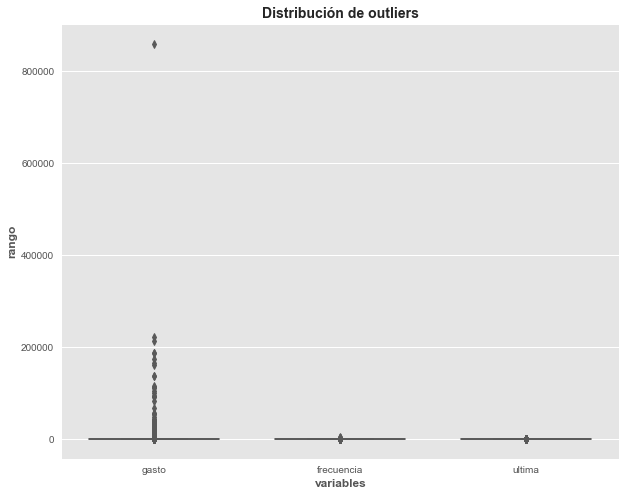

In [772]:
variables = ['gasto','frecuencia','ultima']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df_clus[variables], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Distribución de outliers", fontsize = 14, fontweight = 'bold')
plt.ylabel("rango", fontweight = 'bold')
plt.xlabel("variables", fontweight = 'bold');

In [773]:
# Sacamos los outliers de cada variable:
Q1 = df_clus.gasto.quantile(0.05)
Q3 = df_clus.gasto.quantile(0.95)
IQR = Q3 - Q1
df_clus = df_clus[(df_clus.gasto >= Q1 - 1.5*IQR) & (df_clus.gasto <= Q3 + 1.5*IQR)]

Q1 = df_clus.frecuencia.quantile(0.05)
Q3 = df_clus.frecuencia.quantile(0.95)
IQR = Q3 - Q1
df_clus = df_clus[(df_clus.frecuencia >= Q1 - 1.5*IQR) & (df_clus.frecuencia <= Q3 + 1.5*IQR)]

Q1 = df_clus.ultima.quantile(0.05)
Q3 = df_clus.ultima.quantile(0.95)
IQR = Q3 - Q1
df_clus = df_clus[(df_clus.ultima >= Q1 - 1.5*IQR) & (df_clus.ultima <= Q3 + 1.5*IQR)]

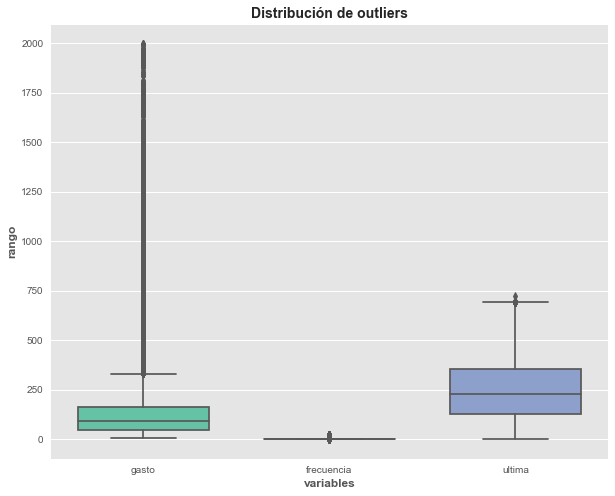

In [774]:
variables = ['gasto','frecuencia','ultima']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df_clus[variables], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Distribución de outliers", fontsize = 14, fontweight = 'bold')
plt.ylabel("rango", fontweight = 'bold')
plt.xlabel("variables", fontweight = 'bold');

In [775]:
#gasto_median = df_clus.gasto_prom.median()
#gasto_media

In [776]:
#df_clus['gasto_binary'] = (df_clus['gasto_prom'] > gasto_median).astype(int)
#df_clus.head()
#df_clus.info()

In [777]:
# Definimos las variables para clusterizar:
df_clus_num = df_clus[['gasto', 'frecuencia', 'ultima']]

# Escalamos las variables
scaler = StandardScaler()

# fit_transform
df_clus_scaled = scaler.fit_transform(df_clus_num)
print(df_clus_scaled.shape)
df_clus_scaled

(67163, 3)


array([[-0.30343994, -0.30411165,  0.28111449],
       [ 0.10023292, -0.30411165,  2.01069249],
       [-0.03444406, -0.30411165,  0.88646679],
       ...,
       [-0.49097617, -0.30411165, -0.96950345],
       [ 0.1893462 , -0.30411165, -1.12250458],
       [-0.31507703,  3.23400656,  0.773379  ]])

In [778]:
# lo miramos como df:
df_clus_scaled_dfkm = pd.DataFrame(df_clus_scaled)
df_clus_scaled_dfkm.columns = ['gasto', 'frecuencia', 'ultima']
df_clus_scaled_dfkm.sample(5)


,gasto,frecuencia,ultima
5291,0.865193,-0.304112,0.141418
62174,-0.180355,-0.304112,0.686900
30617,0.099383,0.201334,0.999555
28987,-0.280166,-0.304112,0.174679
27023,0.637330,-0.304112,-0.364151


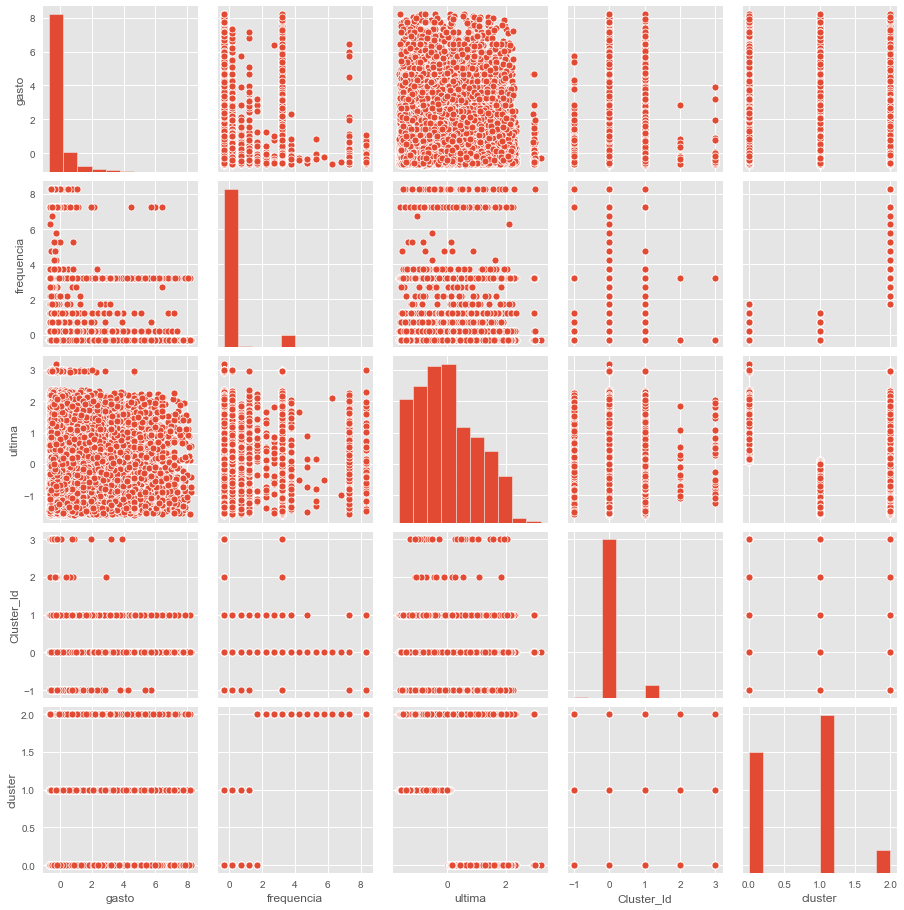

In [779]:
sns.pairplot(df_clus_scaled_df);

## K-MEANS

For n_clusters = 2 The average silhouette_score is : 0.6835591335352829
For n_clusters = 3 The average silhouette_score is : 0.46957614349867016
For n_clusters = 4 The average silhouette_score is : 0.4778652510641512
For n_clusters = 5 The average silhouette_score is : 0.4131617459762111
For n_clusters = 6 The average silhouette_score is : 0.42950944760292453


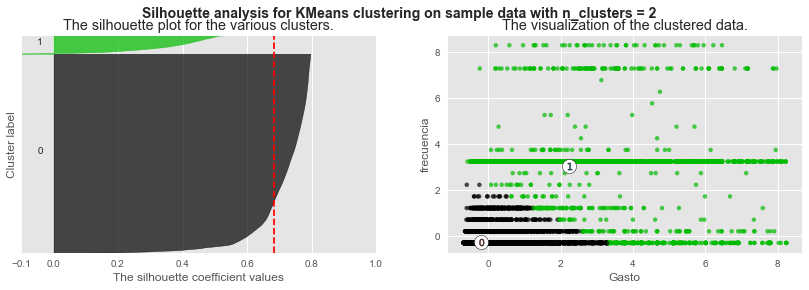

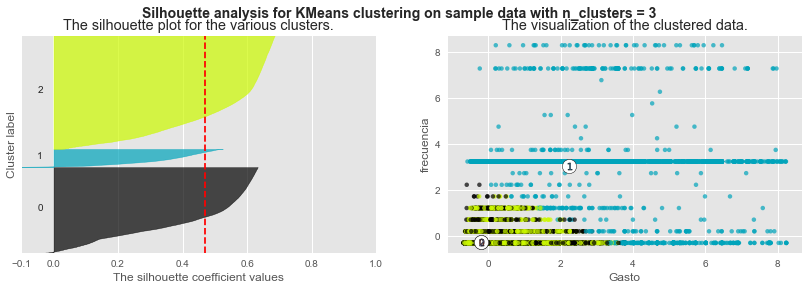

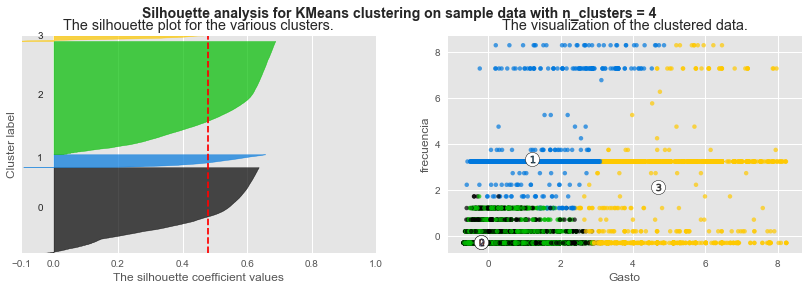

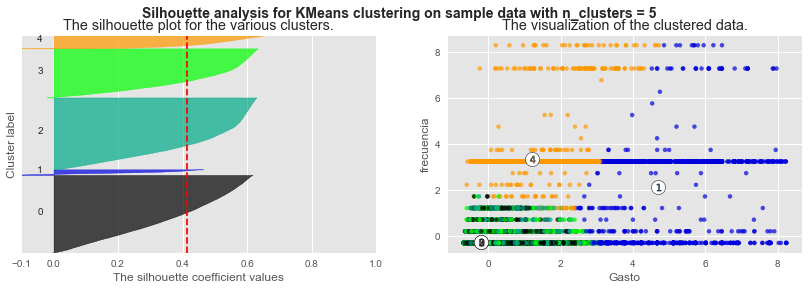

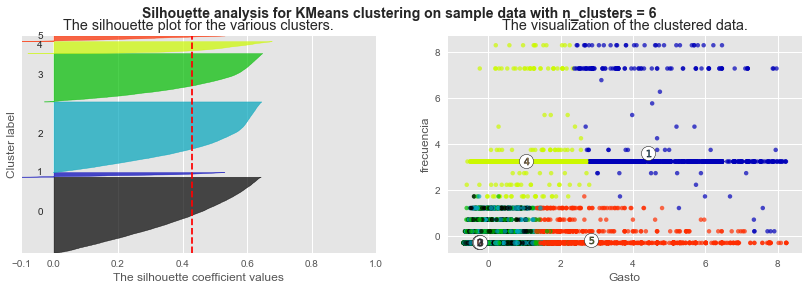

In [780]:
for n_clusters in range(2,7):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(14, 4)

    ax1.set_xlim([-0.1, 1])
  
    ax1.set_ylim([0, len(df_clus_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(df_clus_scaled)

    silhouette_avg = silhouette_score(df_clus_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(df_clus_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(df_clus_scaled[:, 0], df_clus_scaled[:, 1], marker='.', s=80, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
   
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Gasto")
    ax2.set_ylabel("frecuencia")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


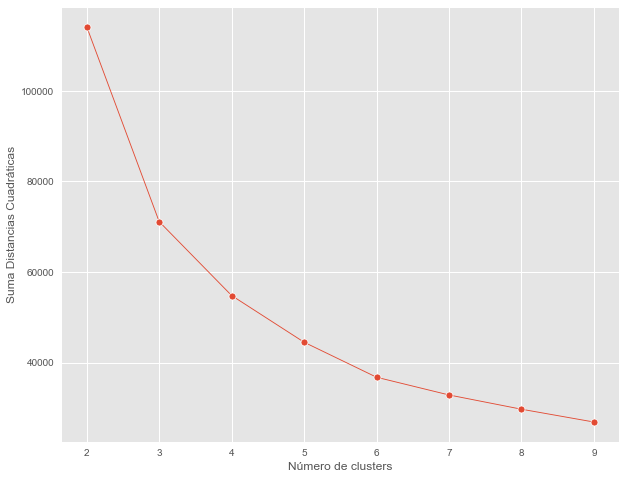

In [781]:
sq_distances=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=42) # Numero de repeticiones=10
    kmeans.fit(df_clus_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters');

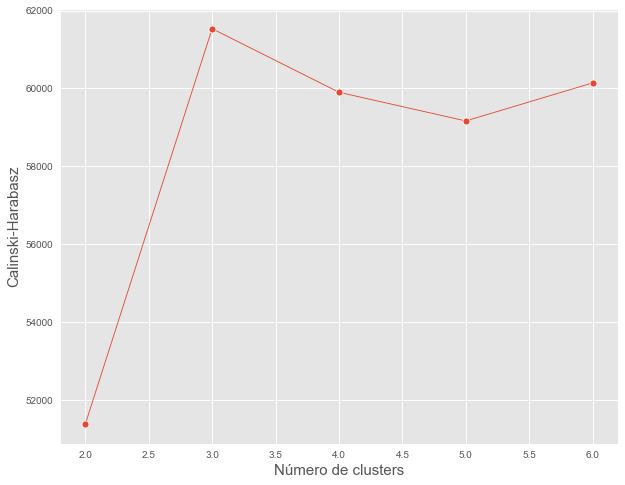

In [782]:
from sklearn.metrics import calinski_harabasz_score

k_values=range(2,7);
ch_scores=[]

for k in k_values:
    
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(df_clus_scaled)
    score=calinski_harabasz_score(df_clus_scaled,kmeans.labels_)
    ch_scores.append(score)

sns.lineplot(x=k_values,y=ch_scores,marker='o',size=30,legend=False);
plt.ylabel('Calinski-Harabasz',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

In [800]:
# Nos decidimos por K = 4, fiteamos:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(df_clus_scaled)


KMeans(max_iter=50, n_clusters=4)

In [801]:
kmeans.labels_

array([0, 0, 0, ..., 2, 2, 3], dtype=int32)

In [802]:
# asignamos las etiquetas al df:
df_clus_scaled_dfkm['cluster'] = kmeans.labels_
df_clus_scaled_dfkm.head()

,gasto,frecuencia,ultima,cluster
0,-0.303440,-0.304112,0.281114,0
1,0.100233,-0.304112,2.010692,0
2,-0.034444,-0.304112,0.886467,0
3,-0.289117,-0.304112,-0.636892,2
4,-0.436864,-0.304112,1.724647,0


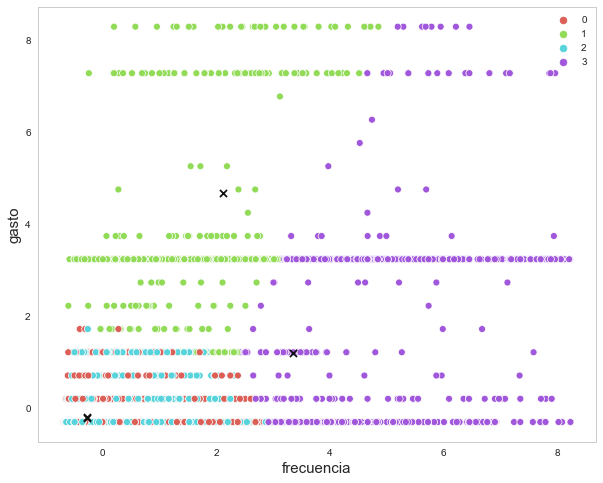

In [803]:
kmeans=KMeans(n_clusters=4,n_init=10,random_state=42) # Numero de repeticiones=10
kmeans.fit(df_clus_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=df_clus_scaled[:,0],y=df_clus_scaled[:,1],hue=labels,legend='full',palette=sns.color_palette("hls", 4));
plt.xlabel('frecuencia',fontsize=15);plt.ylabel('gasto',fontsize=15);
plt.scatter(centroids[:,1],centroids[:,0],marker='x',s=50,color='k');


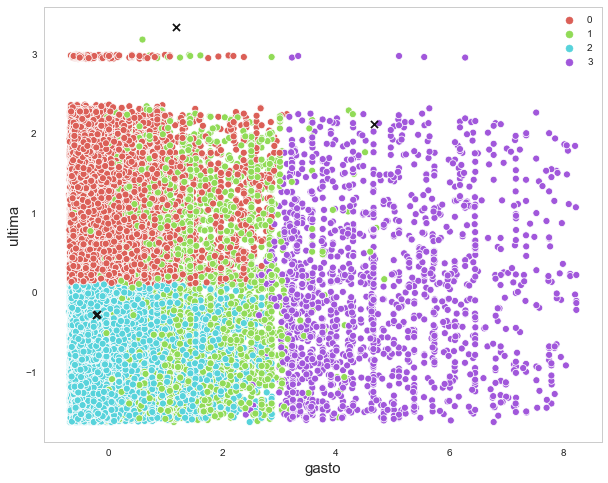

In [804]:
kmeans=KMeans(n_clusters=4,n_init=10,random_state=42) # Numero de repeticiones=10
kmeans.fit(df_clus_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=df_clus_scaled[:,0],y=df_clus_scaled[:,2],hue=labels,legend='full',palette=sns.color_palette("hls", 4));
plt.xlabel('gasto',fontsize=15);plt.ylabel('ultima',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');


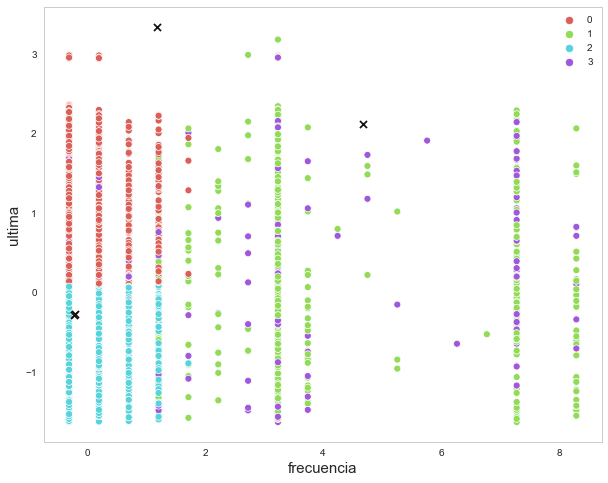

In [805]:
kmeans=KMeans(n_clusters=4,n_init=10,random_state=42) # Numero de repeticiones=10
kmeans.fit(df_clus_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=df_clus_scaled[:,1],y=df_clus_scaled[:,2],hue=labels,legend='full',palette=sns.color_palette("hls", 4));
plt.xlabel('frecuencia',fontsize=15);plt.ylabel('ultima',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');

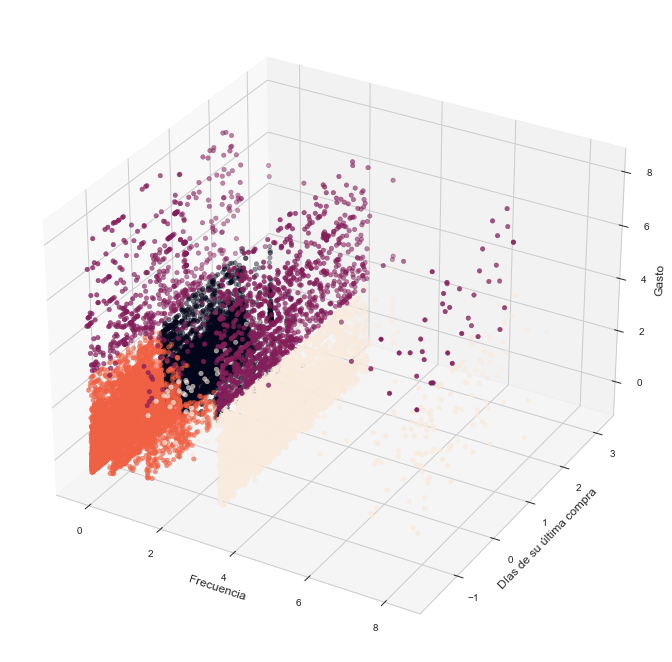

In [943]:
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(9,9))

ax = Axes3D(fig)

x = df_clus_scaled_dfkm.frecuencia
y = df_clus_scaled_dfkm.ultima
z = df_clus_scaled_dfkm.gasto


ax.scatter(x, y, z, c=df_clus_scaled_dfkm.cluster, marker='o')
ax.set_xlabel('Frecuencia')
ax.set_ylabel('Días de su última compra')
ax.set_zlabel('Gasto')
plt.show()

In [944]:
#import plotly.express as px
#df = df_clus_scaled_dfkm
#fig = px.scatter_3d(df, x='frecuencia' , y='ultima', z='gasto',color='cluster', width=600, height=500,
#               opacity=1)
#fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
#fig.update_traces(marker=dict(size=4),
#                  selector=dict(mode='markers'))
#fig.show()


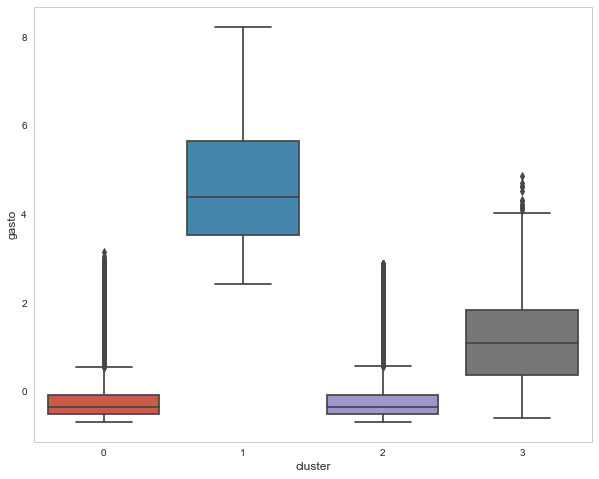

In [807]:
# Boxplot con Cluster vs Gasto:

sns.boxplot(x='cluster', y='gasto', data=df_clus_scaled_dfkm);

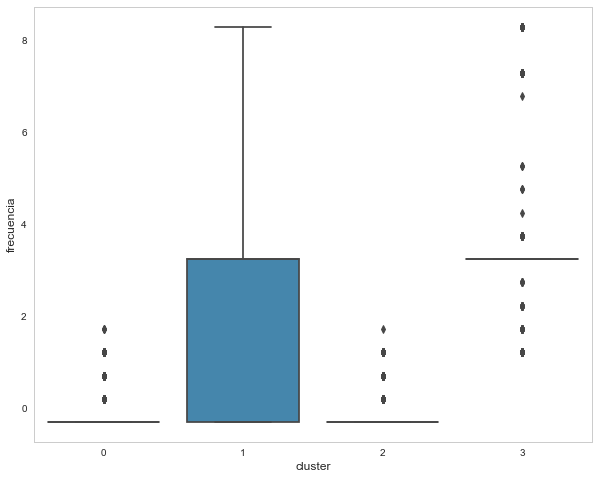

In [808]:
# Boxplot con Cluster vs Frecuencia:

sns.boxplot(x='cluster', y='frecuencia', data=df_clus_scaled_dfkm);

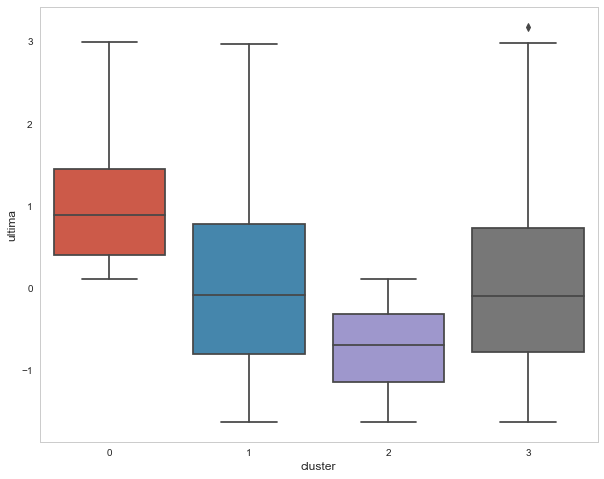

In [809]:
# Boxplot con Cluster vs Última:

sns.boxplot(x='cluster', y='ultima', data=df_clus_scaled_dfkm);

## DBSCAN

In [862]:
df_clus_scaled_db = df_clus_scaled

In [874]:
# Implementamos DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=20)
y_dbscan = dbscan.fit_predict(df_clus_scaled_db)

y_dbscan

array([0, 0, 0, ..., 0, 0, 1])

In [875]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3])

In [876]:
print("Silhouette Coefficient: %0.3f" % silhouette_score(df_clus_scaled_db, dbscan.labels_))
print("Calinsky-Harabasz Index: %0.3f" % calinski_harabasz_score(df_clus_scaled_db, dbscan.labels_))

Silhouette Coefficient: 0.662
Calinsky-Harabasz Index: 12939.849


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

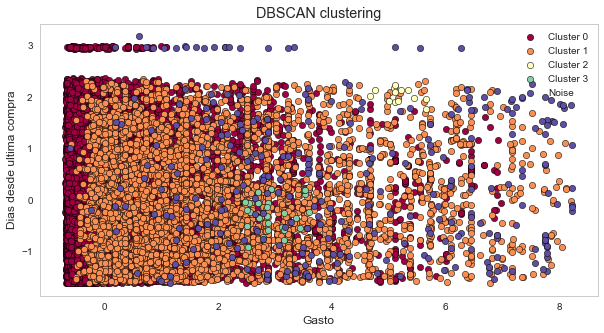

In [877]:
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

labels = dbscan.labels_
unique_labels=set(labels);

fig, ax = plt.subplots(figsize=(10,5))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i,l in enumerate(unique_labels):
    if l ==-1:
        ax.scatter(df_clus_scaled[labels==l,0], df_clus_scaled[labels==l,2],c =colors[i], edgecolor='black', marker='o',s=40,label='Noise')
    else:
        ax.scatter(df_clus_scaled[labels==l,0], df_clus_scaled[labels==l,2],c =colors[i], edgecolor='black', marker='o',s=40,label='Cluster '+str(l))
    
ax.legend()
ax.set_title('DBSCAN clustering');
ax.set_xlabel("Gasto")
ax.set_ylabel("Dias desde ultima compra")  ;  

In [878]:
df_clus['Cluster_Id'] = dbscan.labels_
df_clus['Cluster_Id'].value_counts()

 0    61988
 1     4842
-1      292
 3       27
 2       14
Name: Cluster_Id, dtype: int64

In [890]:
df_clus.sample(10)

,customer_id,gasto,frecuencia,ultima,Cluster_Id
41125,986f579e98bbb0ae992a7263a1196d46,29.0,1,7,0
57155,d3343ef400ee50f5a78951026cdec7aa,25.0,1,517,0
48708,b3ecd12dae46566a71a2ccc14908355a,31.9,1,427,0
29466,6da387a19f90d3b3b07a576590e7d48d,219.0,1,201,0
48710,b3ef2e15b1f2d5598a28e08e3536542b,47.3,1,267,0
58306,d76512c766b6191a31760b27a3a671fd,184.0,8,586,1
58145,d6cf4dc1013cd7678d71fa00d606d2d1,139.9,1,527,0
13211,308800cb1d6dd4e3d0a89f43d8fa44c7,707.4,18,126,-1
54812,ca8bff97326e402bf9add2e236ea5534,220.0,1,417,0
11352,2995f8ff3dd359e487a35225923d8ca1,27.9,1,164,0


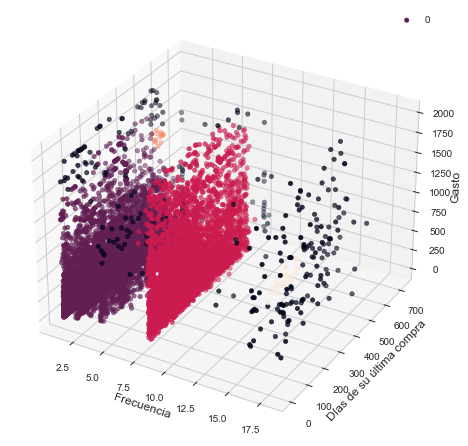

In [902]:
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = df_clus.frecuencia
y = df_clus.ultima
z = df_clus.gasto


ax.scatter(x, y, z, c=df_clus.Cluster_Id, marker='o')
ax.set_xlabel('Frecuencia')
ax.set_ylabel('Días de su última compra')
ax.set_zlabel('Gasto')
ax.legend(dbscan.labels_) 
plt.show()



Vemos que el cluster 2 (naranja) es un pequeño grupo de clientes que gastan muy por encima de la media pero que compraron pocas veces y hace mucho. 
Ya que son pocos se recomendaría una acción de por parte de la empresa para reconectarse y no perderlos...

In [945]:
#from mpl_toolkits.mplot3d import Axes3D          
#fig = plt.figure(figsize=(9, 9))     
#ax = fig.add_subplot(111, projection='3d')      
#xs = df_clus.frecuencia      
#ys = df_clus.ultima
#zs = df_clus.gasto
#ax.scatter(xs, ys, zs, s=50, alpha=0.6, c=dbscan.labels_, cmap='plasma')      
#ax.set_xlabel('Frecuencia')      
#ax.set_ylabel('Dias de su última compra')      
#ax.set_zlabel('Gasto')      
#ax.legend(dbscan.labels_) 

(235965, 8)

In [946]:
#import plotly.express as px
#df = df_clus
#fig = px.scatter_3d(df, x='frecuencia' , y='ultima', z='gasto',color='Cluster_Id', width=700, height=600,
#               opacity=1)
#fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
#fig.update_traces(marker=dict(size=4),
#                  selector=dict(mode='markers'))
#fig.show()
